In [2]:
import chess
import chess.polyglot
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from collections import Counter


pgn = open("lichess_db_standard_rated_2014-12.pgn")

for i in range(3):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    print(f"partie {i + 1}:\n")
    print(game)
    print("\n" + "-" * 50 + "\n")

partie 1:

[Event "Rated Bullet game"]
[Site "https://lichess.org/kkoeqcF0"]
[Date "????.??.??"]
[Round "?"]
[White "carlsen89"]
[Black "goltrpoat"]
[Result "0-1"]
[UTCDate "2014.11.30"]
[UTCTime "23:00:03"]
[WhiteElo "2070"]
[BlackElo "1918"]
[WhiteRatingDiff "-15"]
[BlackRatingDiff "+16"]
[ECO "B18"]
[Opening "Caro-Kann Defense: Classical Variation"]
[TimeControl "60+0"]
[Termination "Normal"]

1. e4 c6 2. d4 d5 3. Nd2 dxe4 4. Nxe4 Bf5 5. Ng3 Bg6 6. Nf3 Nd7 7. Bd3 Ngf6 8. c4 e6 9. Qc2 Be7 10. Bg5 O-O 11. O-O b5 12. cxb5 cxb5 13. Bxb5 Bxc2 0-1

--------------------------------------------------

partie 2:

[Event "Rated Blitz tournament https://lichess.org/tournament/X5BO0Amj"]
[Site "https://lichess.org/IqsDiXIt"]
[Date "????.??.??"]
[Round "?"]
[White "nunutsu"]
[Black "sergeblanc"]
[Result "0-1"]
[UTCDate "2014.11.30"]
[UTCTime "23:00:40"]
[WhiteElo "1406"]
[BlackElo "1567"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[ECO "A40"]
[Opening "Horwitz Defense"]
[TimeControl "300+0"]


In [3]:
with open("lichess_db_standard_rated_2014-12.pgn") as f:
    nb_parties = sum(1 for line in f if line.startswith("[Event "))
print(f"Nombre total de parties : {nb_parties}")


Nombre total de parties : 1350176


# Autour de l'ELO


In [40]:
#On va essayer de génerer 4000 échantillons sur la base de données pour appliquer ensuite le test de Shapiro
import random 
reservoir_sampling = []
k = 4000
i = 0

while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    diff_str = game.headers.get("WhiteRatingDiff")
    elo_str = game.headers.get("WhiteElo")

    if diff_str is None or elo_str is None:
        continue

    diff = int(diff_str)
    elo = int(elo_str)
    
    if not (-10 < diff < 10):
        continue
    i += 1
    if(len(reservoir_sampling)) < k:
        reservoir_sampling.append(elo)
    else:
        j = random.randint(0, i- 1)
        if j < k :
            reservoir_sampling[j] = elo

x = scipy.stats.shapiro(reservoir_sampling)
print(x.pvalue)


2.0577235938851337e-07


La p-value (2.0577235938851337e-07) étant très inférieure à 0.05, on peut rejetter H0 = "La distribution de ELO suit une loi normale".

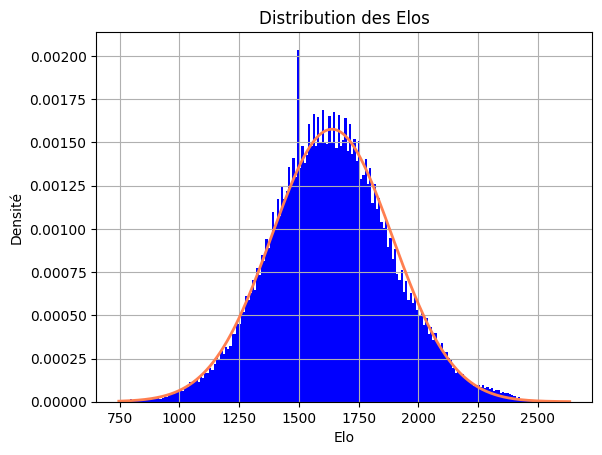

In [3]:
array = []
while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    diff = int(game.headers.get("WhiteRatingDiff", 999))
    if( -10 < diff < 10):
        array.append(int(game.headers.get("WhiteElo")))

mean_array = np.mean(array)
std_array = np.std(array)
array.sort()

x = np.linspace(min(array), max(array), 1000)
y = scipy.stats.norm.pdf(x, mean_array, std_array)

plt.hist(array, bins=200, density=True, color='blue', label="Distribution de la base")
plt.plot(x, y, color='coral', linewidth=2, label="Gaussienne théorique")

plt.title('Distribution des Elos', fontsize=12)
plt.xlabel('Elo')
plt.ylabel('Densité')
plt.grid()
plt.show()

In [3]:
bullet_stats = Counter()
blitz_stats = Counter()
classical_stats = Counter()
blitz_stats_ECO = Counter()
opening_followups = {} 

for _ in range(20000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    if game.headers.get("Opening") == "?":
        continue

    event = game.headers.get("Event", "")
    opening = game.headers.get("Opening", "Unknown")

    board = game.board()
    moves = list(game.mainline_moves())
    san_moves = []
    for move in moves:
        san = board.san(move)
        san_moves.append(san)
        board.push(move)

    if opening not in opening_followups:
        opening_followups[opening] = Counter()

    if len(san_moves) > 4:
        fifth_move = san_moves[4]
        opening_followups[opening][fifth_move] += 1

    if "Rated Bullet" in event:
        bullet_stats[opening] += 1
    elif "Rated Blitz" in event:
        blitz_stats[opening] += 1
    elif "Rated Classical" in event:
        classical_stats[opening] += 1


In [5]:
from scipy.stats import chi2_contingency

top5_openings = [opening for opening, _ in blitz_stats.most_common(5)]
openings_results = {opening: Counter() for opening in top5_openings}


for _ in range(20000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    headers = game.headers

    if headers.get("Opening") == "?":
        continue

    if "Rated Blitz" not in headers.get("Event", ""):
        continue

    white_elo_str = headers.get("WhiteElo", "")
    black_elo_str = headers.get("BlackElo", "")

    if not white_elo_str.isdigit() or not black_elo_str.isdigit():
        continue

    white_elo = int(white_elo_str)
    black_elo = int(black_elo_str)

    if not (1200 <= white_elo <= 1600 and 1200 <= black_elo <= 1600):
        continue

    opening = headers["Opening"]
    result = headers["Result"]

    if opening in top5_openings:
        openings_results[opening][result] += 1

results = ['1-0', '0-1', '1/2-1/2']
contingency_table = []

for opening in top5_openings:
    row = [openings_results[opening].get(r, 0) for r in results]
    contingency_table.append(row)

print(chi2_contingency(contingency_table))
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi² = {chi2:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("Il existe une association significative entre ouverture et résultat pour les ELO 1200–1600")
else:
    print("Aucune association significative détectée dans cette tranche d’ELO")


Chi2ContingencyResult(statistic=np.float64(6.972943215530432), pvalue=np.float64(0.5395546991943805), dof=8, expected_freq=array([[28.45491803, 23.02459016,  1.5204918 ],
       [19.32786885, 15.63934426,  1.03278689],
       [37.58196721, 30.40983607,  2.00819672],
       [22.54918033, 18.24590164,  1.20491803],
       [23.08606557, 18.68032787,  1.23360656]]))

Chi² = 6.97, p-value = 0.5396
Aucune association significative détectée dans cette tranche d’ELO


In [6]:
player_data = {}
pgn = open("lichess_db_standard_rated_2014-12.pgn")

while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    event = game.headers.get("Event")
    if not event or not event.startswith("Rated"):
        continue

    parts = event.split()
    if len(parts) < 3:
        continue
    game_type = parts[1]

    if game_type not in ["Bullet", "Blitz", "Rapid", "Classical"]:
        continue

    for color in ["White", "Black"]:
        player = game.headers.get(color)
        rating_str = game.headers.get(f"{color}Elo")

        if not player or not rating_str:
            continue

        rating = int(rating_str)

        if player not in player_data:
            player_data[player] = {
                "Bullet": [], "Blitz": [], "Rapid": [], "Classical": []
            }

        player_data[player][game_type].append(rating)


# Construire un DataFrame des joueurs ayant ≥ 3 parties 
records = []
for player, ratings_by_type in player_data.items():
    record = {"player": player}
    count_types = 0
    for game_type in ["Bullet", "Blitz", "Rapid", "Classical"]:
        ratings = ratings_by_type[game_type]
        if len(ratings) >= 3:
            record[game_type] = sum(ratings) / len(ratings)
            count_types += 1
    if count_types >= 2:
        records.append(record)

df = pd.DataFrame(records)
print(df.head())

      player       Bullet        Blitz    Classical
0  goltrpoat  1926.000000  2076.333333  2071.000000
1    nunutsu          NaN  1391.778481  1519.088235
2     piongu  2250.871681  2372.362319  2337.800000
3  bumblebee  1166.250000  1376.380417          NaN
4   Exodus_z          NaN  1304.035971  1453.600000


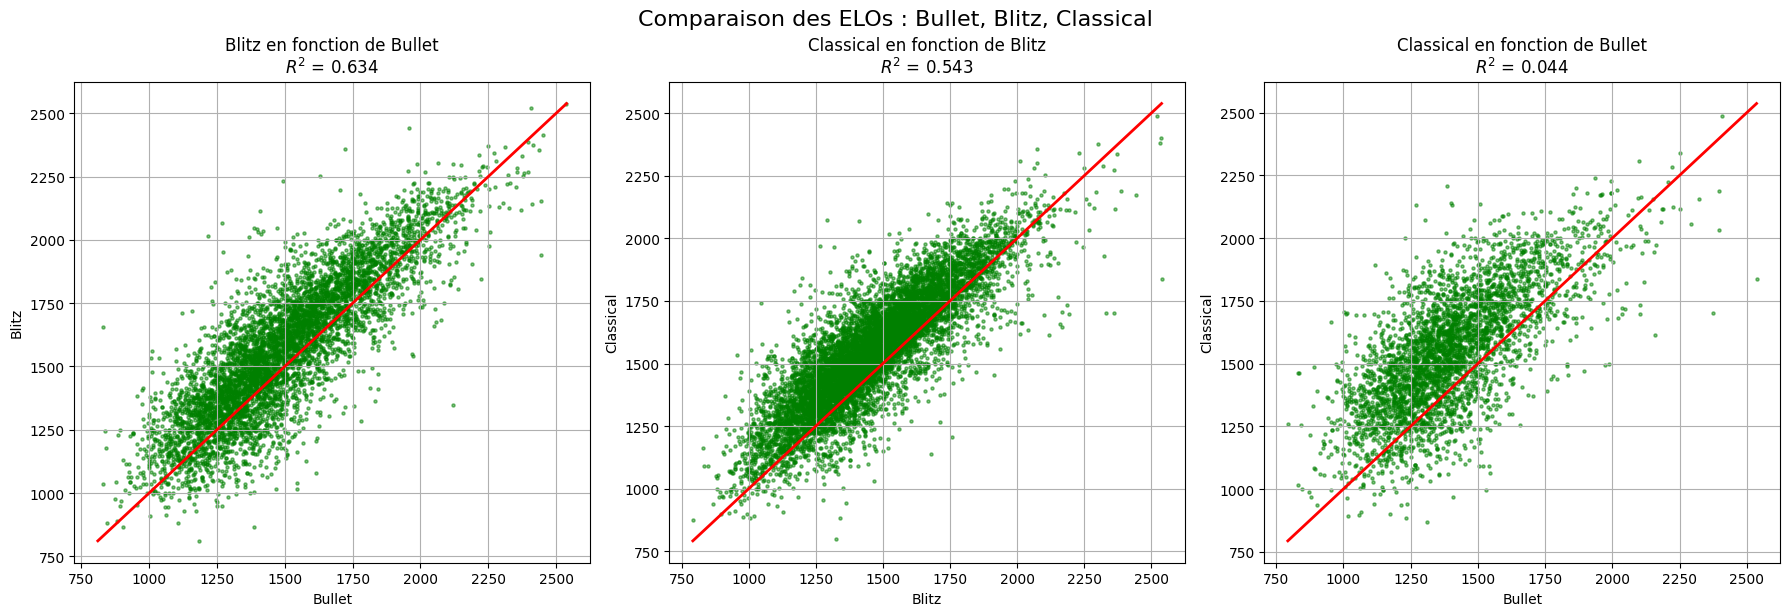

In [10]:
import matplotlib.pyplot as plt
import numpy as np

types = ["Bullet", "Blitz", "Classical"]

plt.figure(figsize=(18, 6))

comparisons = [
    ("Bullet", "Blitz"),
    ("Blitz", "Classical"),
    ("Bullet", "Classical")
]

for i, (x_type, y_type) in enumerate(comparisons):
    df_plot = df.dropna(subset=[x_type, y_type])
    if df_plot.empty:
        continue

    X = df_plot[x_type].values
    y = df_plot[y_type].values

    y_pred = X
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else 0

    min_val = min(X.min(), y.min())
    max_val = max(X.max(), y.max())

    plt.subplot(1, 3, i + 1)
    plt.scatter(X, y, alpha=0.5, s=5, color='green')
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2) 
    plt.xlabel(x_type)
    plt.ylabel(y_type)
    plt.title(f"{y_type} en fonction de {x_type}\n$R^2$ = {r2:.3f}")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Comparaison des ELOs : Bullet, Blitz, Classical", fontsize=16, y=1.02)
plt.show()


# Autour des ouvertures


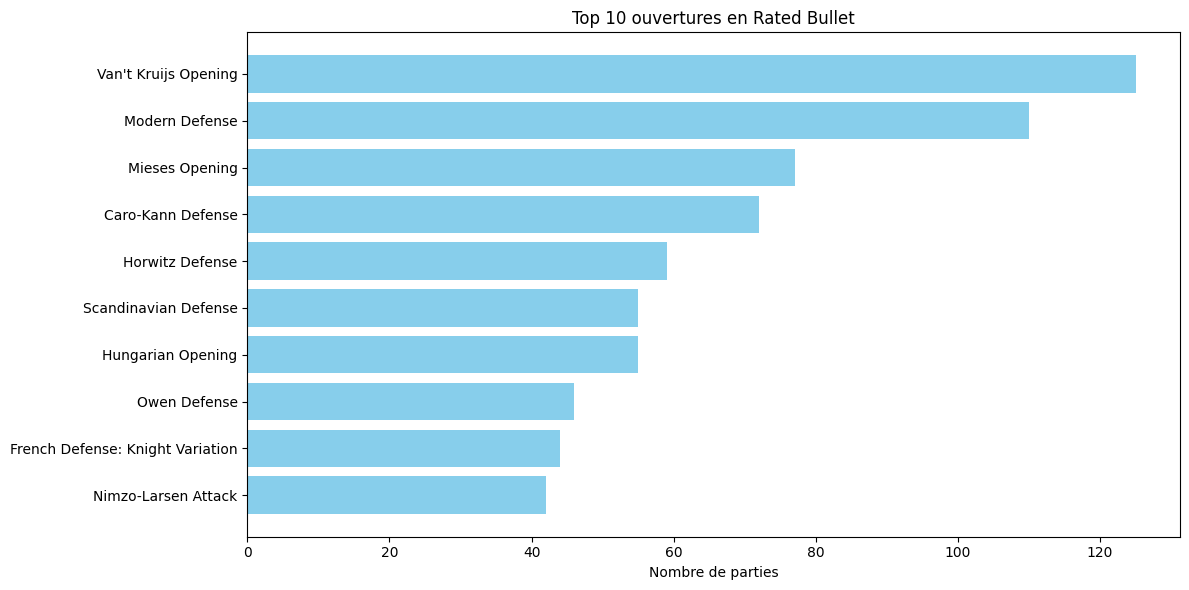

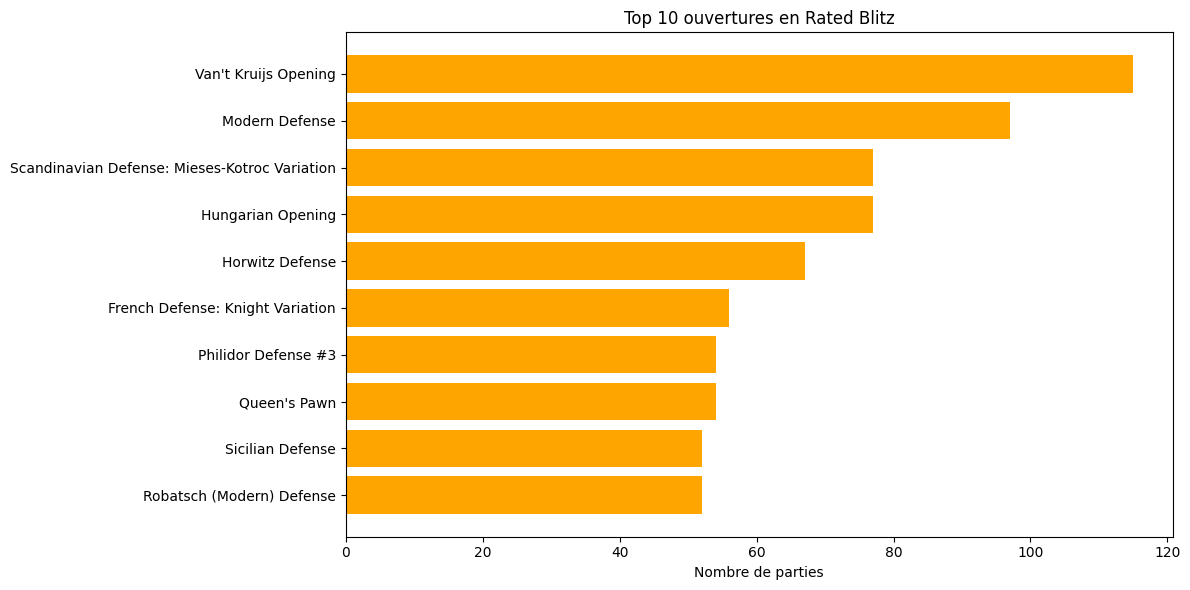

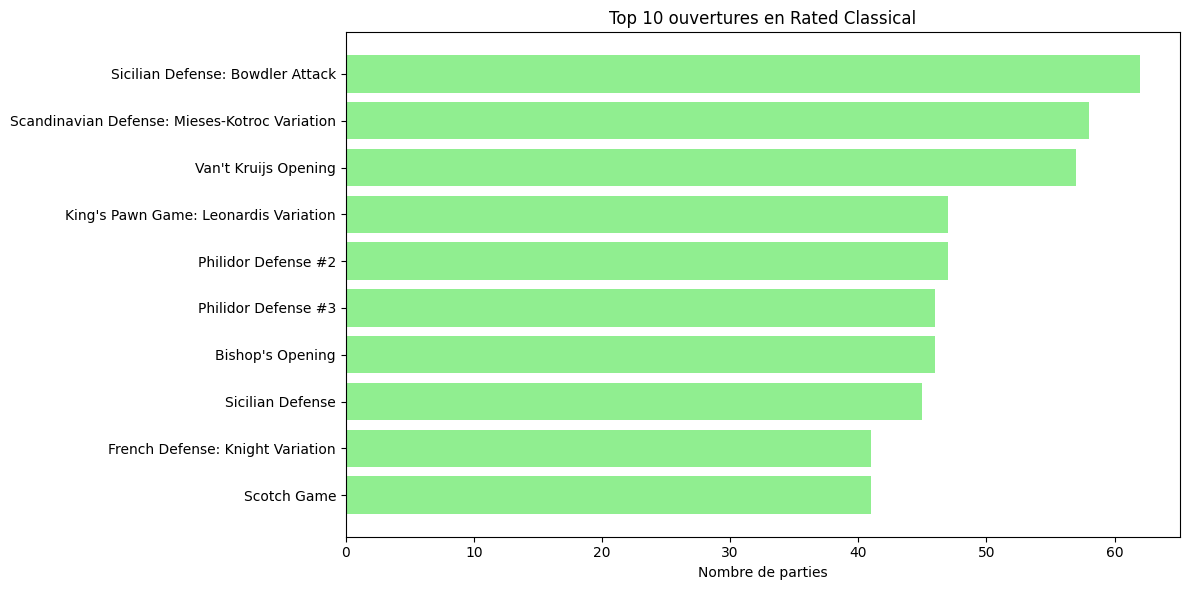

In [7]:
def plot_openings(stats, title, color):
    top_openings = stats.most_common(10)
    openings = [item[0] for item in top_openings]
    counts = [item[1] for item in top_openings]

    plt.figure(figsize=(12, 6))
    plt.barh(openings[::-1], counts[::-1], color=color)
    plt.xlabel("Nombre de parties")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_openings(bullet_stats, "Top 10 ouvertures en Rated Bullet", "skyblue")
plot_openings(blitz_stats, "Top 10 ouvertures en Rated Blitz", "orange")
plot_openings(classical_stats, "Top 10 ouvertures en Rated Classical", "lightgreen")


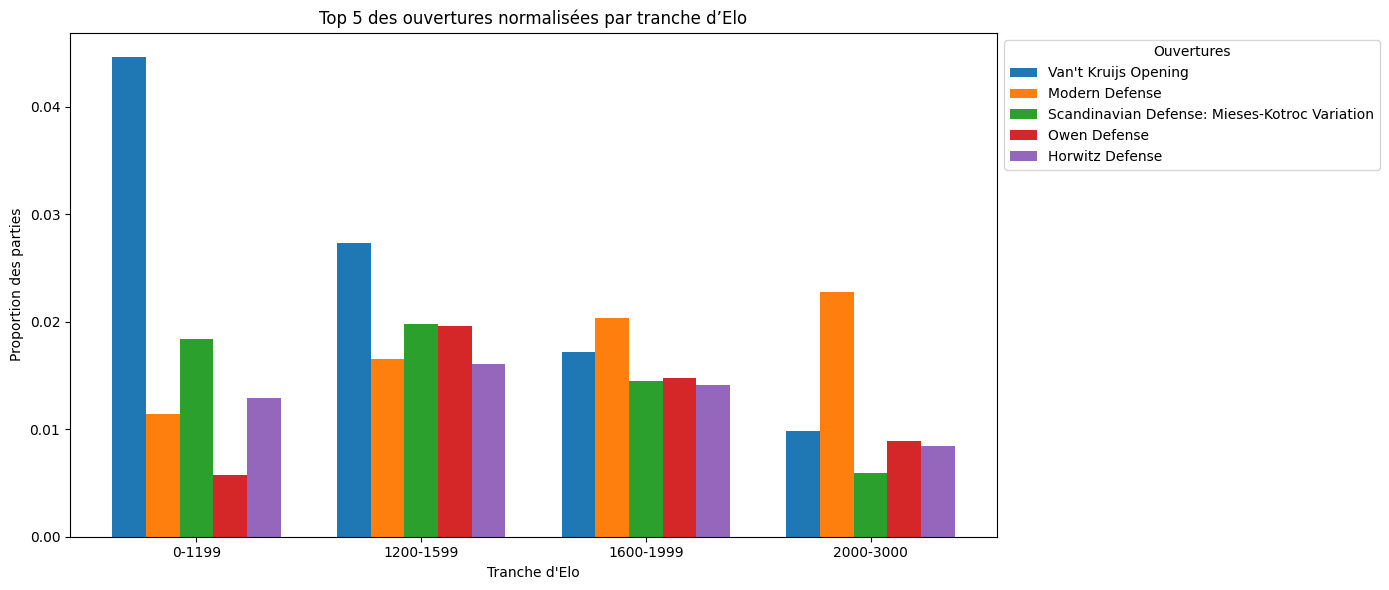

In [ ]:
elo_ranges = [(0, 1199), (1200, 1599), (1600, 1999), (2000, 3000)]
elo_labels = [f"{low}-{high}" for low, high in elo_ranges]
elo_opening_stats = {label: Counter() for label in elo_labels}

while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    white_elo = int(game.headers.get("WhiteElo", 0))
    black_elo = int(game.headers.get("BlackElo", 0))
    average_elo = (white_elo + black_elo) // 2
    opening = game.headers.get("Opening", "Unknown")

    for (low, high), label in zip(elo_ranges, elo_labels):
        if low <= average_elo <= high:
            elo_opening_stats[label][opening] += 1
            break

total_opening_counts = sum(elo_opening_stats.values(), Counter())
top_openings = [opening for opening, _ in total_opening_counts.most_common(5)]

bar_width = 0.15
x = np.arange(len(elo_labels))

plt.figure(figsize=(14, 6))

for i, opening in enumerate(top_openings):
    counts = []
    for label in elo_labels:
        total = sum(elo_opening_stats[label].values())
        if total > 0:
            count = elo_opening_stats[label][opening] / total
        else:
            count = 0
        counts.append(count)

    plt.bar(x + i * bar_width, counts, width=bar_width, label=opening)

plt.xlabel("Tranche d'Elo")
plt.ylabel("Proportion des parties")
plt.title("Top 5 des ouvertures normalisées par tranche d’Elo")
plt.xticks(x + bar_width * 2, elo_labels)
plt.legend(title="Ouvertures", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


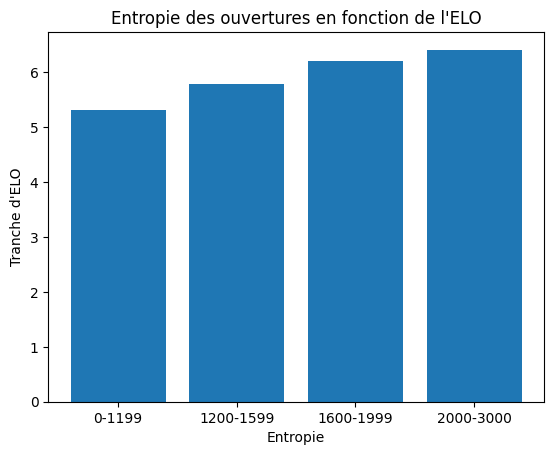

In [17]:

only_openings = [opening for opening in total_opening_counts.keys()]


entropy = []

for label in elo_labels:
    total = sum(elo_opening_stats[label].values())
    entrop = 0
    for i, opening in enumerate(only_openings):
        if total > 0:
            count = elo_opening_stats[label][opening] / total
            if count!=0:
                entrop -= count * np.log(count)
    entropy.append(entrop)
    
plt.bar(elo_labels, entropy)
plt.xlabel("Entropie")
plt.ylabel("Tranche d'ELO")
plt.title("Entropie des ouvertures en fonction de l'ELO")
plt.show()
        

In [3]:
import tkinter as tk
from tkinter import ttk
import os
from PIL import Image, ImageTk

# Variables globales pour gérer les GIFs animés
current_board_image = None
frames = []
animation_job = None
gif_index = 0

def update_openings(event=None):
    mode = mode_var.get()
    if mode == "Bullet":
        current_stats = bullet_stats
    elif mode == "Blitz":
        current_stats = blitz_stats
    else:
        current_stats = classical_stats

    top_openings = [opening for opening, _ in current_stats.most_common(10)]
    opening_var.set(top_openings[0] if top_openings else "")
    menu_openings["menu"].delete(0, "end")
    for opening in top_openings:
        menu_openings["menu"].add_command(label=opening, command=tk._setit(opening_var, opening, update_stats))

    update_stats()

def get_first_moves(opening):
    moves = []
    for _ in range(10000):
        game = chess.pgn.read_game(pgn)
        if game is None:
            break
        if game.headers.get("Opening") == opening:
            board = game.board()
            for move in game.mainline_moves():
                board.push(move)
                moves.append(board.san(move))
                if len(moves) == 6:
                    return moves
    return moves

def update_stats(*args):
    mode = mode_var.get()
    opening = opening_var.get()
    
    if mode == "Bullet":
        count = bullet_stats.get(opening, 0)
        total = sum(bullet_stats.values())
    elif mode == "Blitz":
        count = blitz_stats.get(opening, 0)
        total = sum(blitz_stats.values())
    else:
        count = classical_stats.get(opening, 0)
        total = sum(classical_stats.values())

    percentage = (count / total) * 100 if total > 0 else 0
    result_label.config(text=f"Nombre de parties jouées : {count}  ({percentage:.2f}%)")

    # Nettoyer les anciens widgets dans move_frame
    for widget in move_frame.winfo_children():
        widget.destroy()

    if opening in opening_followups:
        total_followups = sum(opening_followups[opening].values())
        common_moves = opening_followups[opening].most_common(2)

        tk.Label(move_frame, text="Les coups les plus joués après l'ouverture pour les Blancs :", 
                 font=("Arial", 12, "bold")).pack(anchor="w")
        
        for move, freq in common_moves:
            percent = (freq / total_followups) * 100 if total_followups > 0 else 0
            move_line = f"• {move} ({percent:.1f}%)"
            tk.Label(move_frame, text=move_line).pack(anchor="w")
    else:
        tk.Label(move_frame, text="Données non disponibles").pack(anchor="w")

    show_board()


def show_board():
    global current_board_image, frames, gif_index

    opening = opening_var.get()
    gif_file = os.path.join("images_openings", f"{opening}.gif")

    if os.path.exists(gif_file):
        gif = Image.open(gif_file)
        max_frames = 4
        frames = []

        for i in range(min(gif.n_frames, max_frames)):
            gif.seek(i)
            frame = gif.copy().resize((400, 400))
            frames.append(ImageTk.PhotoImage(frame))

        gif_index = 0
        animate_gif()
    else:
        board_label.config(text="Image non trouvée", image="")
        board_label.image = None

def animate_gif():
    global gif_index, frames
    if frames:
        board_label.config(image=frames[gif_index])
        board_label.image = frames[gif_index]

        if gif_index == len(frames) - 1:
            return
        
        gif_index = (gif_index + 1) % len(frames)
        board_label.after(1000, animate_gif)

# Interface Tkinter
root = tk.Tk()
root.title("Explorateur d'Ouvertures")
root.geometry("500x700")

mode_var = tk.StringVar(value="Blitz")
opening_var = tk.StringVar()

tk.Label(root, text="Mode de jeu :").pack(pady=(10, 0))
mode_menu = ttk.OptionMenu(root, mode_var, "Blitz", "Blitz", "Bullet", "Classical", command=update_openings)
mode_menu.pack(pady=5)

tk.Label(root, text="Ouverture :").pack(pady=(10, 0))
menu_openings = ttk.OptionMenu(root, opening_var, "")
menu_openings.pack(pady=5)

result_label = tk.Label(root, text="Nombre de parties jouées :")
result_label.pack(pady=10)

board_label = tk.Label(root)
board_label.pack(pady=10)

move_frame = tk.Frame(root)
move_frame.pack(pady=10, fill="x", padx=20)

# Initialisation
root.after(1000, update_openings)
root.mainloop()


# Curiosités


In [26]:
count = 0
count_edge = 0
adj = {}
for _ in range(200000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    white_name = game.headers["White"]
    black_name = game.headers["Black"]
    white_elo = int(game.headers.get("WhiteElo", 0))
    black_elo = int(game.headers.get("BlackElo", 0))
    average_elo = (white_elo + black_elo) // 2

    if 0 <= average_elo <= 1200:
        count_edge += 1
        if(not(white_name in adj)):
            count += 1
            adj[white_name] = [black_name]
        else:
            adj[white_name].append(black_name)
        if(not(black_name in adj)):
            count += 1
            adj[black_name] = [white_name]
        else:
            adj[black_name].append(white_name)

print(count)

1772


In [38]:
from collections import deque
players = [players for players,_ in adj.items()]
visited = {}
for i in players:
    visited[i] = False

def dfs(player):
    if(not(visited[player])):
        visited[player] = True
        for i in adj[player]:
            dfs(i)

dfs(players[0])
nbVisited = 0
restraint_adj = {}
for a,i in visited.items():
    if(i):
        restraint_adj[a] = adj[a]



def bfs(graph, start_node): 
    visited = set()
    queue = deque()
    visited.add(start_node)
    queue.append(start_node)
    distances = {}
    distances[start_node] = 0
    l = 0
    while queue:
        m = queue.popleft()
        for neighbour in graph[m]:
            if neighbour not in visited:
                if(i):
                    restraint_adj[a] = adj[a]
                visited.add(neighbour)
                distances[neighbour] = distances[m]+1
                l = max(l, distances[neighbour])
                queue.append(neighbour)
    return l

diameter = 0

for a,i in visited.items():
    if(i):
        diameter = max(diameter, bfs(restraint_adj,a))

print(diameter)

10


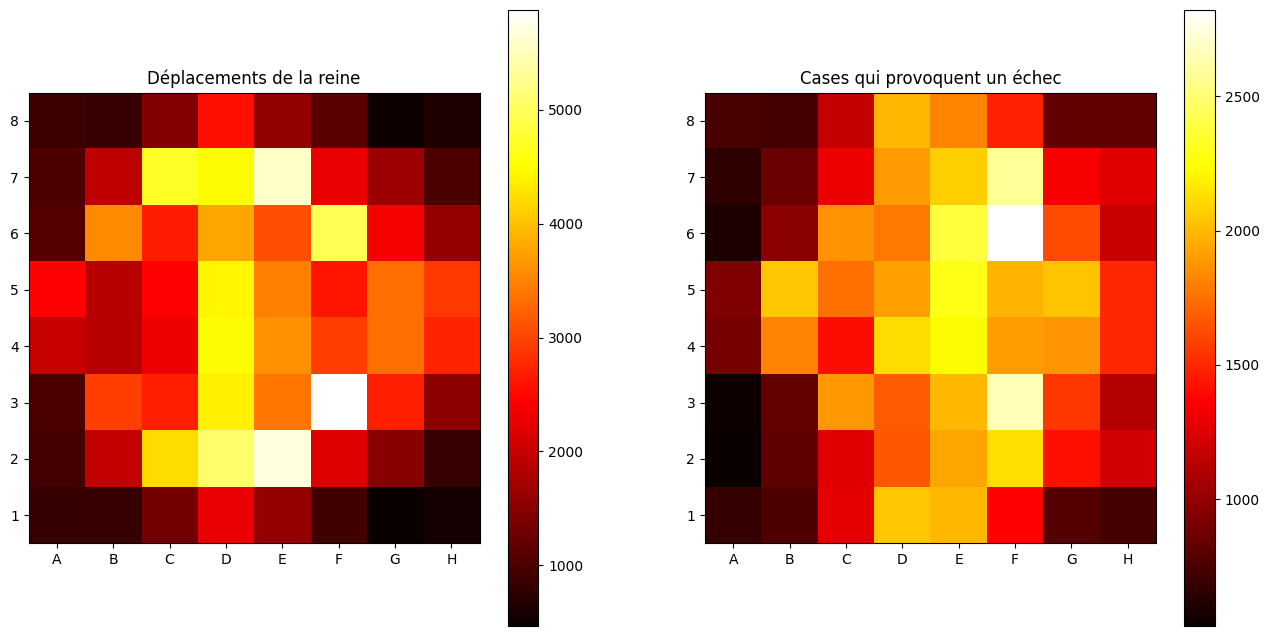

In [2]:
#ON essaie de mesurer la fréquence des coups de Dame et les pièces qui mettent en échecs

queen_moves = Counter()
check_moves = Counter()

for _ in range(20000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    board = game.board()
    for move in game.mainline_moves():
        piece = board.piece_at(move.from_square)
        if piece and piece.piece_type == chess.QUEEN:
            square = move.to_square
            queen_moves[square] += 1
        
        board.push(move)

        if board.is_check():
            check_moves[move.to_square] += 1


board_chess = np.zeros((8,8))
board_chess1 = np.zeros((8,8))


for square, count in queen_moves.items():
    row = chess.square_rank(square)
    column = chess.square_file(square)
    board_chess[7-row, column] = count #Inverse l'axe des rangées pour avoir un échequier avec le blanc en bas

board_chess1 = np.zeros((8,8))

for square, count in check_moves.items():
    row = chess.square_rank(square)
    column = chess.square_file(square)
    board_chess1[7 - row, column] = count #Inverse l'axe des rangées pour avoir un échequier avec le blanc en bas


fig, axs = plt.subplots(1, 2, figsize=(16,8))

im0 = axs[0].imshow(board_chess, cmap="hot", interpolation="nearest")
axs[0].set_title("Déplacements de la reine")
fig.colorbar(im0, ax=axs[0])
axs[0].set_xticks(np.arange(8))
axs[0].set_xticklabels(['A','B','C','D','E','F','G','H'])
axs[0].set_yticks(np.arange(8))
axs[0].set_yticklabels(list(reversed(range(1,9))))

im1 = axs[1].imshow(board_chess1, cmap="hot", interpolation="nearest")
axs[1].set_title("Cases qui provoquent un échec")
fig.colorbar(im1, ax=axs[1])
axs[1].set_xticks(np.arange(8))
axs[1].set_xticklabels(['A','B','C','D','E','F','G','H'])
axs[1].set_yticks(np.arange(8))
axs[1].set_yticklabels(list(reversed(range(1,9))))
plt.show()


On remarque de la case de Qd8 est plus colorée que Qd1, cela vient probablement d'une variante qui est régulièrement joué sur la défense Scandinave ! 

In [ ]:
# On va essayer de déterminer le coup le plus rare joué dans la database 
piece_mouvement_white = Counter()
piece_mouvement_black = Counter()

for _ in range(200000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    board = game.board()
    for move in game.mainline_moves():
        move_san = board.san(move)
        if board.turn == chess.WHITE :
            piece_mouvement_white[move_san] += 1        
        else:
            piece_mouvement_black[move_san] += 1        
        board.push(move)
    
total_moves_white = sum(piece_mouvement_white.values())
total_moves_black = sum(piece_mouvement_black.values())

most_common_move_white, most_common_count_white = piece_mouvement_white.most_common(1)[0]
most_common_move_black, most_common_count_black = piece_mouvement_black.most_common(1)[0]


rarest_move_white, rarest_count_white = piece_mouvement_white.most_common()[-1]
rarest_move_black, rarest_count_black = piece_mouvement_black.most_common()[-1]

pourcentage_max_white = (most_common_count_white / total_moves_white) * 100
pourcentage_max_black = (most_common_count_black / total_moves_black) * 100

pourcentage_min_white = (rarest_count_white / total_moves_white) * 100
pourcentage_min_black = (rarest_count_black / total_moves_black) * 100




print("=== Statistiques sur les coups analysés ===")
print(f"Nombre total de coups des Blancs : {total_moves_white}")
print(f"Nombre total de coups des Noirs  : {total_moves_black}\n")

print(f"Coup le plus fréquent chez les Blancs : {most_common_move_white} (soit {pourcentage_max_white:5f}%)")
print(f"Coup le plus fréquent chez les Noirs  : {most_common_move_black} (soit {pourcentage_max_black:5f}%)\n")


print(f"Coup le moins fréquent chez les Blancs : {rarest_move_white} (soit {pourcentage_min_white:5f}%)")
print(f"Coup le moins fréquent chez les Noirs  : {rarest_move_black} (soit {pourcentage_min_black:5f}%)\n")




=== Statistiques sur les coups analysés ===
Nombre total de coups des Blancs : 6585063
Nombre total de coups des Noirs  : 6482207

Coup le plus fréquent chez les Blancs : Nf3 (soit 2.838242%)
Coup le plus fréquent chez les Noirs  : Nf6 (soit 2.584089%)

Coup le moins fréquent chez les Blancs : Bxe2# (soit   0.000015%)
Coup le moins fréquent chez les Noirs  : Rdb5+ (soit   0.000015%)

